# Логистическая регрессия и разделяющая гиперплоскость

## Модули и функции

https://www.baeldung.com/cs/gradient-descent-logistic-regression|

https://math.stackexchange.com/questions/1652661/gradient-descent-l2-norm-regularization

In [1]:
# Модули, настройка, функции

import numpy as np
np.random.seed(seed=3)
import pandas as pd
from matplotlib import pyplot as plt, cm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Графики и оси
def get_shiny_square_axes(axes, axes_arrows=True, axes_labels=('x1', 'x2'), xlim=(-1, 1), ylim=(-1, 1), hw=0.1, lw=1):
  '''Общая настройка осей 2d графиков'''
  if axes_arrows:
    axes.arrow(xlim[0], 0, xlim[1] - xlim[0], 0, length_includes_head=True, head_width=hw, lw=lw, color='r')
    axes.arrow(0, ylim[0], 0, ylim[1] - ylim[0], length_includes_head=True, head_width=hw, lw=lw, color='g')
  axes.grid(True)
  axes.set_aspect(aspect=1) # adjustable='datalim'
  axes.set_axisbelow(True)
  axes.set_xlim(xlim)
  axes.set_ylim(ylim)
  axes.set_xlabel(axes_labels[0])
  axes.set_ylabel(axes_labels[1])

def get_shiny_cubic_axes(axes, axes_arrows=True, axes_labels=('x1', 'x2', 'y'), xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1), alr=0.02, lw=1):
  '''Общая настройка осей 3d графиков'''
  if axes_arrows:
    axes.quiver(xlim[0], 0, 0, xlim[1] - xlim[0], 0, 0, arrow_length_ratio=alr, normalize=False, linewidth=lw, color='r')
    axes.quiver(0, ylim[0], 0, 0, ylim[1] - ylim[0], 0, arrow_length_ratio=alr, normalize=False, linewidth=lw, color='g')
    axes.quiver(0, 0, zlim[0], 0, 0, zlim[1] - zlim[0], arrow_length_ratio=alr, normalize=False, linewidth=lw, color='b')
  axes.grid(True)
  axes.set_axisbelow(True)
  axes.set_xlim(xlim)
  axes.set_ylim(ylim)
  axes.set_zlim(zlim)
  axes.set_xlabel(axes_labels[0])
  axes.set_ylabel(axes_labels[1])
  axes.set_zlabel(axes_labels[2])

# Генерация и разметка данных
def generate_data(mu_neg=(0, 0), sigma_neg=1, size_neg=1, mu_pos=(0, 0), sigma_pos=1, size_pos=1):
  '''
  Генерация матрицы признаков X типа pandas.DataFrame и вектора целевого
  признака y типа pandas.Series.

  Входные параметры:
    mu_neg    - математическое ожидание объектов класса -1;
    sigma_neg - стандартное отклонение объектов класса -1;
    size_neg  - количество объектов класса -1; 
    mu_pos    - математическое ожидание объектов класса +1;
    sigma_pos - стандартное отклонение объектов класса +1;
    size_pos  - количество объектов класса +1
  '''
  x0 = [1] * (size_neg + size_pos) # Фиктивный признак
  x1 = np.hstack((mu_neg[0] + sigma_neg * np.random.randn(size_neg), mu_pos[0] + sigma_pos * np.random.randn(size_pos)))
  x2 = np.hstack((mu_neg[1] + sigma_neg * np.random.randn(size_neg), mu_pos[1] + sigma_pos * np.random.randn(size_pos)))
  y = np.hstack((-np.ones(size_neg), np.ones(size_pos)))
  X = pd.DataFrame(np.column_stack((x0, x1, x2, y)), columns=['x0', 'x1', 'x2', 'y'])
  X = X.sort_values(by='x1').reset_index(drop=True)
  y = X.y
  del X['y']
  return X, y

def separate_linearly(fuatures, coefficients, clear_distance=0):
  '''
  Разметка данных с помощью гиперплоскости. Объектам с отрицательной дистанцией
  до разделяющей гиперплоскости присваивается класс -1, с положительной - +1.
  Объекты на расстоянии от гиперплоскости меньше d удаляются.

  Входные параметры:
    X - матрица признаков;
    w - коэффициенты гиперплоскости вида [w0, w1, w2], где w0 - свободный член;
    d - расстояние от гиперплоскости, в пределах которого удаляются объекты
  '''
  # Вычислим для каждого дистанцию до гиперплоскости d
  fuatures['d'] = fuatures @ coefficients / np.linalg.norm(coefficients[1:])
  # Удаление объектов внутри полосы
  fuatures = fuatures.drop(X[abs(fuatures.d) <= clear_distance].index)
  fuatures = fuatures.reset_index(drop=True)
  # Новые значений целевого признака
  target = np.sign(fuatures.d).astype(int)
  del fuatures['d']
  return fuatures, target

def sigmoid(x):
  '''Сигмойда'''
  return 1 / (1 + np.exp(-x))

sigmoid = np.vectorize(sigmoid)

def sigmoid_derivative(x):
  '''Производная сигмойды'''
  s = sigmoid(x)
  return (1 - s) * s

sigmoid_derivative = np.vectorize(sigmoid_derivative)

def negative_log_likelihood(X, y, w):
  '''Функция отрицательного логарифмического правдоподобия'''
  return np.sum(-y * (X @ w) + np.log(1 + np.exp(X @ w))) / X.shape[1]

def negative_log_likelihood_gradient(X, y, w):
  '''Градиент функции отрицательного логарифмического правдоподобия'''
  return np.array((-y + sigmoid(X @ w)) @ X) / X.shape[1]
  
class MyShinyLogisticRegression():
  '''
  Собственноручная логистическая регрессия. Умеет обучаться градиентным спуском
  с регуляризацией (L1, L2, ElsticNet) или без, умеет классифицировать объекты.
  Работает только с вещественными признаками, при этом матрица признаков должна
  содержать фиктивный признак в первом столбце.

  Входные параметры:
    iterations     - количество итераций;
    eta0           - скорость обучения;
    penalty_type   - тип регуляризации;
    penalty_weight - коэффициент регуляризации;
    verbose        - вывод в процессе обучения
  '''
  
  def __init__(self, iterations=1, eta0=0.01, penalty_type='l2', penalty_weight=1, verbose=False):
    self.iterations = iterations
    self.eta0 = eta0
    self.penalty_type = penalty_type
    self.penalty_weight = penalty_weight
    self.verbose = verbose

  def fit(self, X, y):
    '''Тяжело в учении...'''

    # Инициализация вектора весов и свободного члена
    self.w = np.zeros(X.shape[1])
    self.b = 0

    # Выбор функции регуляризации
    self.set_penalty_function()

    # Градиентный спуск
    for i in range(self.iterations):
      self.update_wights(X, y)
      if self.verbose:
        print('Шаг: {:<6} свободный член: {:<9} коэффициенты: {:<17} Negative log likelihood: {:<.4f}'.\
          format(i, str(self.b.round(4)), str(self.w.round(4)), self.negative_log_likelihood(X, y)))

  def set_penalty_function(self):
    '''Выбор функции вычисления регуляризационного члена'''
    if self.penalty_type == 'l2':
      self.calculate_penalty = lambda: self.w
    elif self.penalty_type == 'l1':
      self.calculate_penalty = lambda: np.sign(self.w)
    elif self.penalty_type == 'elasticnet':
      self.calculate_penalty = lambda: self.w + np.sign(self.w)
    elif self.penalty_type == 'none':
      self.calculate_penalty = lambda: np.zeros_like(self.w)
    else:
      raise ValueError('Неверное значение аргумента penalty_type')

  def negative_log_likelihood(self, X, y):
    '''Усредненная функция отрицательного логарифмического правдоподобия'''
    a = X @ self.w + self.b
    return np.sum(-y * a + np.log(1 + np.exp(a))) / X.shape[1]

  def update_wights(self, X, y):
    '''Обновление весов'''
    # Регуляризационный член функции потерь
    penalty = self.calculate_penalty()
    # Градиенты
    a = X @ self.w + self.b
    s = sigmoid(a)
    gw = np.array((-y + s) @ X) / X.shape[1]
    gb = np.sum(np.array(-y + s)) / X.shape[1] # Сумма вместо умножения на вектор из 1
    # Коррекция весов градиентным спуском, свободный член не штрафуется, т.к.
    # имеет право быть большим
    self.w -= self.eta0 * (gw + self.penalty_weight * penalty)
    self.b -= self.eta0 * gb

  def predict(self, X):
    '''...легко в бою'''
    a = X @ self.w + self.b
    return np.where(sigmoid(a) >= 0.5, 1, 0)

  @property
  def coef_(self):
    return np.array([self.w])

  @property
  def intercept_(self):
    return self.b

## Генерация даных

Сгенерируем выборку из `SIZE_NEG` объектов отрицательного класса и `SIZE_POS` объектов положительного класса в $\mathbb{R^2}$ признаковом пространстве. Оба признака распределены нормально с математическим ожиданием и стандартным отклонением `MU_NEG`, `SIGMA_NEG` и `MU_POS`, `SIGMA_POS` соответственно для отрицательного и положительного классов.
<br><br>

Для получения линейно разделимых классов (`LIN_SEP_FLA = True`) используется гиперплоскость $x_2 w_2 + x_1 w_1 + w_0 = 0$, задаваемая нормалью $\{w_0, w_1, w_2\}$, и представляющая в двумерном признаковом пространстве прямую $x_2 = -\frac{w_1}{ w_2} x_1 - \frac{w_0}{ w_2}$.
<br><br>

Объекты, находящиеся на расстоянии не превышающем `LIN_SEP_CLEAR_DIST` от разделяющей гиперплоскости, удаляются.

In [2]:
# Параметры разметки целевого признака
MU_NEG, SIGMA_NEG = (0.4, 0.4), 0.2
MU_POS, SIGMA_POS = (0.6, 0.6), 0.2
SIZE_NEG = 50
SIZE_POS = 50

# Флаг разметки целевого признака, при которой достигается линейная разделимость
# объектов. Для разметки используется прямая с коэффициентами W (в общем случае
# и далее не прямая, а гиперплоскость)
LIN_SEP_FLAG = True

# Расстояние от разделяющей гиперплоскости, на котором объекты удаляются
LIN_SEP_CLEAR_DIST = 0.05

# Координаты нормали гиперплоскости для рзаметки [w0, w1, w2]
W = np.array([-0.5, 0.4, 0.6])

# Генерация данных
X, y_ = generate_data(MU_NEG, SIGMA_NEG, SIZE_NEG, MU_POS, SIGMA_POS, SIZE_POS)

# Если установлен флаг линейного разделения объектьов
if LIN_SEP_FLAG:
  X, y_ = separate_linearly(X, W, LIN_SEP_CLEAR_DIST)

# Вектор целевой признаков, у которого класс "-1" переименован в "0"
y = y_.replace(-1, 0)

print('Первые несколько строк матрицы признаков:\n', X.head(), '\n')

print('Вектор весов:\n', W)

Первые несколько строк матрицы признаков:
     x0        x1        x2
0  1.0 -0.083817  0.304327
1  1.0 -0.049652  0.567169
2  1.0  0.016852  0.729566
3  1.0  0.027301  0.512897
4  1.0  0.051372  0.648323 

Вектор весов:
 [-0.5  0.4  0.6]


Сгенерированные исходные данные и отобразим их на графике:
- темные точки &mdash; объекты класса 0;
- светлые точки &mdash; объекты класса 1;
- сине-зеленая линия &mdash; гиперплоскость, используемая для разметки при  `LIN_SEP_FLAG = True`;
- сине-зеленая стрелка &mdash; построенный от начала координат вектор нормали, задающей разделяющую гиперплоскость;
- пунктирные линии &mdash; границы области полушириной `LIN_SEP_CLEAR_DIST`, в которой при флаге `LIN_SEP_FLAG = True` удаляются объекты.

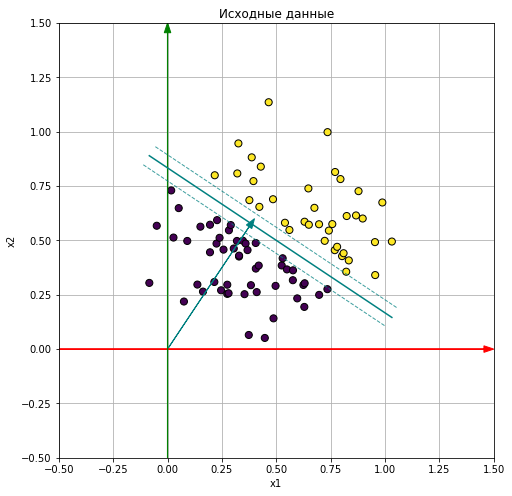

In [3]:
# Кооррдинаты разделяющей гиперплоскости (линия на графике)
hp = pd.DataFrame({'x0': X.x0, 'x1': X.x1})
hp['x2'] = (-hp.x1 * W[1] - hp.x0 * W[0]) / W[2]

# Координаты границ области, свободной от объектов (пунктирнвые линии на графике)
ba = hp - LIN_SEP_CLEAR_DIST * W / np.linalg.norm(W[1:])
bb = hp + LIN_SEP_CLEAR_DIST * W / np.linalg.norm(W[1:])

# Невообразимая красота
_, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X.x1, X.x2, c=y, s=50, edgecolor='black')
ax.plot(ba.x1, ba.x2, linestyle='--', lw=1, color='teal', alpha=0.75)
ax.plot(bb.x1, bb.x2, linestyle='--', lw=1, color='teal', alpha=0.75)
ax.plot(hp.x1, hp.x2, linestyle='-', color='teal')
ax.arrow(0, 0, W[1], W[2], length_includes_head=True, head_width=0.03, color='teal')
# for i, r in X.iterrows():
#   ax.annotate(i, (r.x1 + 0.02, r.x2 + 0.02))
get_shiny_square_axes(axes=ax, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), hw=0.03)
ax.set_title('Исходные данные');

Построим поверхность функции отрицательного логарифмического правдоподобия. Так как в нашем случае данная функция является функцией трех переменных $w_0, w_1$ и $w_2$, для отображения ее значений понадобится четырехмерная система координат.
<br><br>

Построим поверхность отрицательной функции логарифмического правдоподобия в координатах $w_1$ и $w_2$ для фиксированного значения свободного члена $w_0$, использованного при разметке выборки на предыдущем этапе.
<br><br>

В общем случае минимум функции не будет совпадать с вектором $\{w_0, w_1, w_2\}$, использованным для разметки данных, т.к. с точки зрения логистической регрессии разделение может быть неоптимальным.
<br><br>

Вектор $\{w_0, w_1, w_2\}$ на координатной плоскости $w_1 O w_2$ обозначен сине-зеленой точкой.

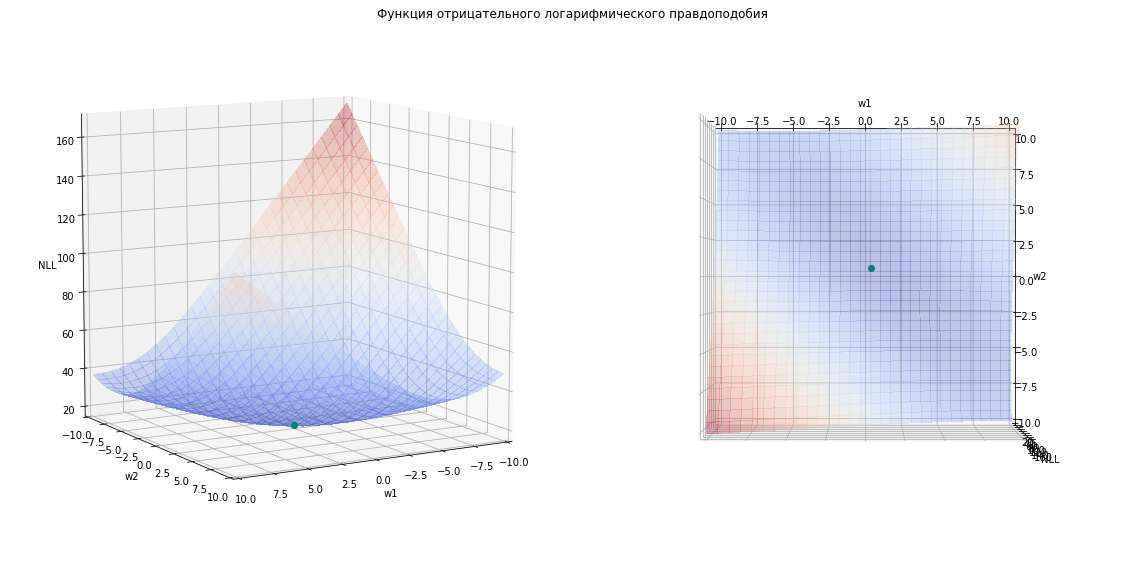

In [4]:
# Координатная сетка
x_min, x_max = -10, 10
y_min, y_max = -10, 10
w1 = np.linspace(x_min, x_max, 30)
w2 = np.linspace(y_min, y_max, 30)
w1, w2 = np.meshgrid(w1, w2)

# Поверхность функции отрицательного логарифмического правдоподобия
nll = np.zeros_like(w1)
for i in range(w1.shape[0]):
  for j in range(w1.shape[1]):
    nll[i, j] = negative_log_likelihood(X, y, [W[0], w1[i, j], w2[i, j]])

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), subplot_kw={'projection': '3d'})
ax0.plot_surface(w1, w2, nll, cmap=cm.coolwarm, lw=0, antialiased=False, alpha=.3)
ax0.plot([W[1]], [W[2]], [nll.flatten().min()], marker='o', color='teal')
ax0.view_init(10, 60)
get_shiny_cubic_axes(axes=ax0, axes_arrows=False, axes_labels=('w1', 'w2', 'NLL'), xlim=(x_min, x_max), ylim=(y_min, y_max), zlim=(nll.flatten().min(), nll.flatten().min() + (nll.flatten().max() - nll.flatten().min()) / 1))
ax1.plot_surface(w1, w2, nll, cmap=cm.coolwarm, lw=0, antialiased=False, alpha=.3)
ax1.plot([W[1]], [W[2]], [nll.flatten().min()], marker='o', color='teal')
ax1.view_init(90, -90)
get_shiny_cubic_axes(axes=ax1, axes_arrows=False, axes_labels=('w1', 'w2', 'NLL'), xlim=(x_min, x_max), ylim=(y_min, y_max), zlim=(nll.flatten().min(), nll.flatten().min() + (nll.flatten().max() - nll.flatten().min()) / 1))
fig.suptitle('Функция отрицательного логарифмического правдоподобия')
fig.tight_layout();

Градиент отрицательной функции логарифмического правдоподобия.
<br><br>

Также строится в координатной плоскости $w_1 O w_2$ для фиксированного значения $w_0$, использованного для разметки целевого признака. Как и на предыдущем графике вектор $\{w_0, w_1, w_2\}$ на координатной плоскости $w_1 O w_2$ обозначен сине-зеленой точкой.

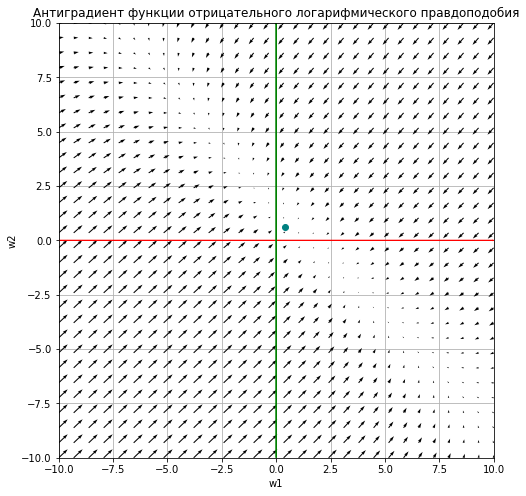

In [5]:
# Координатная сетка
x_min, x_max = -10, 10
y_min, y_max = -10, 10
w1 = np.linspace(x_min, x_max, 30)
w2 = np.linspace(y_min, y_max, 30)
w1, w2 = np.meshgrid(w1, w2)

# Поверхность антиградиента функции отрицательного логарифмического правдоподобия
nllag = np.zeros((30, 30, 3))
for i in range(w1.shape[0]):
  for j in range(w1.shape[1]):
    nllag[i, j] = -negative_log_likelihood_gradient(X, y, [W[0], w1[i, j], w2[i, j]])

_, ax = plt.subplots(figsize=(8, 8))
ax.quiver(w1, w2, nllag[:, :, 1], nllag[:, :, 2])
ax.plot(W[1], W[2], marker='o', color='teal')
get_shiny_square_axes(axes=ax, axes_labels=('w1', 'w2'), xlim=(x_min, x_max), ylim=(y_min, y_max), hw=0.03)
ax.set_title('Антиградиент функции отрицательного логарифмического правдоподобия');

Модель логистической регрессии библиотеки Scikit-learn, обученная на полной выборке. Удаление объектов вблизи разделяющей гиперплоскости (линейная разделимость классов), используемой для разметки объектов, позволяет приблизиться к 100% точности классификации.
<br><br>

Связь логистической и линейной регрессий:
$$\log \frac{p(y=1|w, x)}{1-p(y=1|w, x)}=x_n w_n+ ... + x_1 w_1 + w_0 \Rightarrow$$
$$\Rightarrow p(y=1|w, x)=\frac{1}{1+e^{-(x_n w_n+ ... + x_1 w_1 + w_0)}}.$$

In [6]:
# Модель логистической регрессии
m = LogisticRegression(random_state=0).fit(X[['x1', 'x2']], y)
m_y_pred = m.predict(X[['x1', 'x2']])

# Точность и коэффициенты
m_w = np.hstack((m.intercept_, m.coef_.flatten()))
print(f'Точность на обучающей выборке:\n {accuracy_score(y, m_y_pred):.2%}\n')
print(f'Коэффиценты обученной модели логистической регрессии:\n {m_w}')

Точность на обучающей выборке:
 96.59%

Коэффиценты обученной модели логистической регрессии:
 [-3.3581419   3.1260648   3.01515566]


Моя модель.

In [7]:
# Хорошая, блестящая, своя
mm = MyShinyLogisticRegression(iterations=50, eta0=0.2, penalty_type='l2', penalty_weight=0.01, verbose=True)
mm.fit(X[['x1', 'x2']], y)
mm_y_pred = mm.predict(X[['x1', 'x2']])

# Точность и коэффициенты
mm_w = np.hstack((mm.intercept_, mm.coef_.flatten()))
print(f'\nТочность на обучающей выборке:\n {accuracy_score(y, mm_y_pred):.2%}\n')
print(f'Коэффиценты обученной модели логистической регрессии:\n {mm_w}')

Шаг: 0      свободный член: -0.7      коэффициенты: [0.3984 0.2182]   Negative log likelihood: 27.9768
Шаг: 1      свободный член: -0.528    коэффициенты: [1.1518 0.8402]   Negative log likelihood: 27.1392
Шаг: 2      свободный член: -2.138    коэффициенты: [0.9443 0.5257]   Negative log likelihood: 31.2288
Шаг: 3      свободный член: -0.1699   коэффициенты: [2.5195 2.0148]   Negative log likelihood: 43.6163
Шаг: 4      свободный член: -4.0235   коэффициенты: [1.2385 0.5915]   Negative log likelihood: 53.9181
Шаг: 5      свободный член: -0.7085   коэффициенты: [3.5161 2.7678]   Negative log likelihood: 45.1450
Шаг: 6      свободный член: -4.6757   коэффициенты: [2.1478 1.2731]   Negative log likelihood: 47.0741
Шаг: 7      свободный член: -1.4591   коэффициенты: [4.3407 3.3817]   Negative log likelihood: 40.6501
Шаг: 8      свободный член: -5.2109   коэффициенты: [3.0085 1.9596]   Negative log likelihood: 39.2425
Шаг: 9      свободный член: -2.1963   коэффициенты: [5.0453 3.9375]   Neg

Отобразим данные, разделяющую гиперплоскость, использованную для разметки данных, а также гиперплоскости для обеих обученных моделей логистической регрессии:
- темные точки &mdash; объекты класса 0;
- светлые точки &mdash; объекты класса 1;
- сине-зеленые &mdash; гиперплоскость, используемая для разметки при  `LIN_SEP_FLAG = True`, и задающий ее вектор;
- темно-фиолетовые &mdash; гиперплоскость и задающий ее вектор коэффициентов модели логистической регрессии библиотеки Scikit-learn;
- коричневые &mdash; гиперплоскость и задающий ее вектор коэффициентов моей модели логистической регрессии.

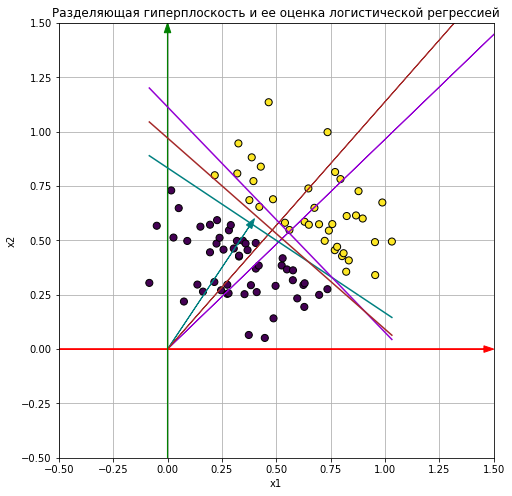

In [8]:
m_hp = pd.DataFrame({'x0': X.x0, 'x1': X.x1})
m_hp['x2'] = (-m_hp.x1 * m_w[1] - m_hp.x0 * m_w[0]) / m_w[2]

mm_hp = pd.DataFrame({'x0': X.x0, 'x1': X.x1})
mm_hp['x2'] = (-mm_hp.x1 * mm_w[1] - mm_hp.x0 * mm_w[0]) / mm_w[2]

_, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X.x1, X.x2, c=y, s=50, edgecolor='black')
ax.plot(hp.x1, hp.x2, linestyle='-', color='teal')
ax.plot(m_hp.x1, m_hp.x2, linestyle='-', color='darkviolet')
ax.plot(mm_hp.x1, mm_hp.x2, linestyle='-', color='brown')
ax.arrow(0, 0, W[1], W[2], length_includes_head=True, head_width=0.03, color='teal')
ax.arrow(0, 0, m_w[1], m_w[2], length_includes_head=True, head_width=0.03, color='darkviolet')
ax.arrow(0, 0, mm_w[1], mm_w[2], length_includes_head=True, head_width=0.03, linestyle='-', color='brown')
# for i, r in X.iterrows():
#   ax.annotate(i, (r.x1 + 0.02, r.x2 + 0.02))
get_shiny_square_axes(axes=ax, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), hw=0.03)
ax.set_title('Разделяющая гиперплоскость и ее оценка логистической регрессией');

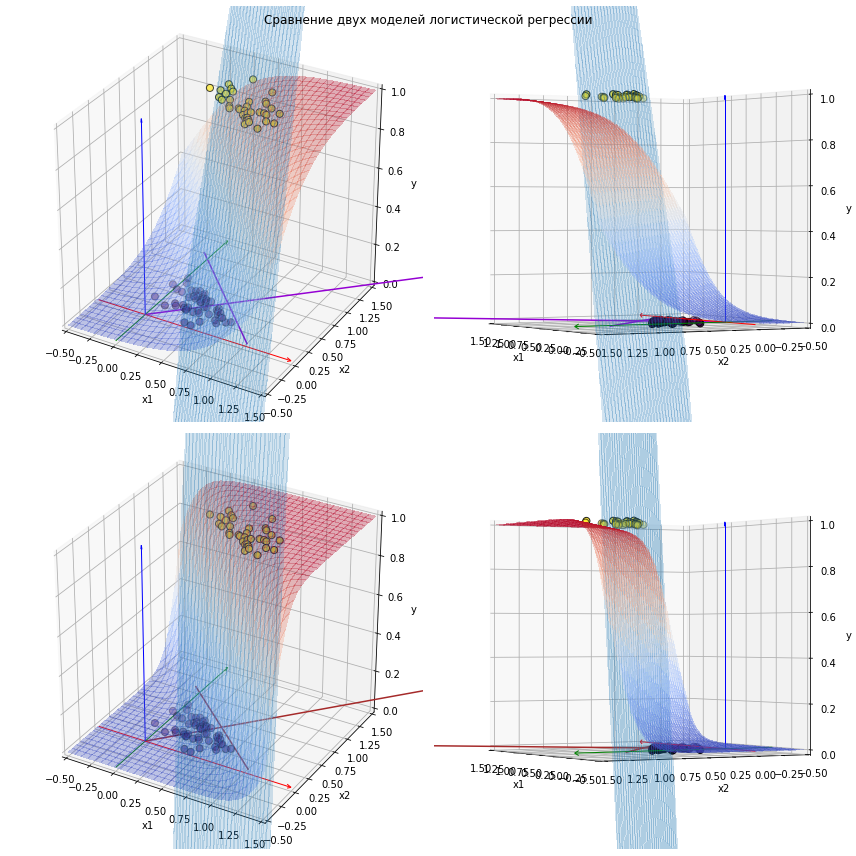

In [9]:
# Координатная сетка для поверхностей на графике
x1 = np.linspace(-0.5, 1.5, 30)
x2 = np.linspace(-0.5, 1.5, 30)
x1, x2 = np.meshgrid(x1, x2)

# Поверхности, образованные значениями линейных комбинаций признаков и
# коэффициентов моделей
m_lc = m_w[2] * x2 + m_w[1] * x1 + m_w[0]
mm_lc = mm_w[2] * x2 + mm_w[1] * x1 + mm_w[0]
# Поверхности, образованные значениями сигмойды от значений линейных комбинаций
# признаков и коэффициентов моделей
m_p = sigmoid(m_lc)
mm_p = sigmoid(mm_lc)

# Один и тот же график с двух ракурсов
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': '3d'})

ax00.plot_surface(x1, x2, m_lc, lw=0, antialiased=False, alpha=.2)
ax00.plot_surface(x1, x2, m_p, cmap=cm.coolwarm, lw=0, antialiased=False, alpha=.3)
ax00.scatter(X.x1, X.x2, y, c=y, s=50, edgecolor='black')
ax00.quiver(0, 0, 0, m_w[1], m_w[2], 0, arrow_length_ratio=0.02, linestyle='-', color='darkviolet')
ax00.plot(m_hp.x1, m_hp.x2, 0, linestyle='-', color='darkviolet')
ax00.view_init(30, -60)
get_shiny_cubic_axes(axes=ax00, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), zlim=(0, 1))

ax01.plot_surface(x1, x2, m_lc, lw=0, antialiased=False, alpha=.2)
ax01.plot_surface(x1, x2, m_p, cmap=cm.coolwarm, lw=0, antialiased=False, alpha=.3)
ax01.scatter(X.x1, X.x2, y, c=y, s=50, edgecolor='black')
ax01.quiver(0, 0, 0, m_w[1], m_w[2], 0, arrow_length_ratio=0.02, linestyle='-', color='darkviolet')
ax01.plot(m_hp.x1, m_hp.x2, 0, linestyle='-', color='darkviolet')
ax01.view_init(0, 150)
get_shiny_cubic_axes(axes=ax01, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), zlim=(0, 1))

ax10.plot_surface(x1, x2, mm_lc, lw=0, antialiased=False, alpha=.2)
ax10.plot_surface(x1, x2, mm_p, cmap=cm.coolwarm, lw=0, antialiased=False, alpha=.3)
ax10.scatter(X.x1, X.x2, y, c=y, s=50, edgecolor='black')
ax10.quiver(0, 0, 0, mm_w[1], mm_w[2], 0, arrow_length_ratio=0.02, color='brown')
ax10.plot(mm_hp.x1, mm_hp.x2, 0, linestyle='-', color='brown')
ax10.view_init(30, -60)
get_shiny_cubic_axes(axes=ax10, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), zlim=(0, 1))

ax11.plot_surface(x1, x2, mm_lc, lw=0, antialiased=False, alpha=.2)
ax11.plot_surface(x1, x2, mm_p, cmap=cm.coolwarm, lw=0, antialiased=False, alpha=.3)
ax11.scatter(X.x1, X.x2, y, c=y, s=50, edgecolor='black')
ax11.quiver(0, 0, 0, mm_w[1], mm_w[2], 0, arrow_length_ratio=0.02, color='brown')
ax11.plot(mm_hp.x1, mm_hp.x2, 0, linestyle='-', color='brown')
ax11.view_init(0, 150)
get_shiny_cubic_axes(axes=ax11, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), zlim=(0, 1))

fig.suptitle('Сравнение двух моделей логистической регрессии')
fig.tight_layout();

## Вывод

&#129322;&#129322;&#129322;